In [1]:
import pint
import os, sys
from utils import *

lib_path = get_project_root()
sys.path.insert(0, lib_path)

from lib.calculator import LinkBudgetCalculator

ModuleNotFoundError: No module named 'ephem'

In [ ]:
ureg = pint.UnitRegistry()

# create the linkBudgetCalculator object
lb_calc = LinkBudgetCalculator(ureg)

## Analysis of Design Iteration X

### Description

<br>
TEMPLATE <br>
DESCRIPTION <br>
FOR <br>
DESIGNS <br>
<br>

![alt text](block_diagram_template.png "Block Diagram")
*<p style="text-align: center;">Block Diagram</p>*


### Setup of Ground Station Values

DESCRIBE PARAMETERS OF GROUND STATION

Values for specific ground station are below:

In [2]:
lb_calc.altitude_ground_station   =  400 * ureg.meter
lb_calc.implementation_loss       = -1.0   # dB
lb_calc.polarization_losses       =  0.0   # dB
lb_calc.receive_antenna_gain      =  5.4   # dB
lb_calc.system_noise_figure       =  5.0   # dB

NameError: name 'ureg' is not defined

### Setup of Satellite Values

Values stated for a certain NOAA satellite. These values are covered in the documentation.

In [3]:
lb_calc.altitude_satellite        =  860 * ureg.kilometer
lb_calc.transmit_power            =  5.0 * ureg.watt
lb_calc.transmit_losses           = -1.0   # dB
lb_calc.transmit_antenna_gain     =  4.0   # dBi

NameError: name 'ureg' is not defined

### Setup of Additional Values

Create functions for the changing elevation angle and atmospheric loss values.

In [4]:
# receive pointing loss for given elevation (at our frequency)
# these values are different for each antenna system, so the values are defined here for clarity
# see referenced antenna specifications for more information
def rx_pointing_loss_at_elev(elev):
    return -10.0 if elev < 5  * ureg.degrees else \
           -6.0  if elev < 20 * ureg.degrees else \
           -3.0  if elev < 35 * ureg.degrees else \
           -1.0  if elev < 50 * ureg.degrees else 0.0

Set paramaters for the analysis here

Additional values are needed for the channel characteristics. A few of these values will change during an orbital pass!

In [6]:
lb_calc.orbit_elevation_angle     =  0.001          * ureg.degrees
lb_calc.downlink_frequency        =  137.5          * ureg.megahertz
lb_calc.target_energy_noise_ratio =  20.0             # dB
lb_calc.noise_bandwidth           =  34.0           * ureg.kilohertz
lb_calc.transmit_pointing_loss    = -3.0              # dB
lb_calc.atmospheric_loss          =  atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
lb_calc.receiving_pointing_loss   =  rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

### Analysis

Define variables for running a sweep over an orbital pass.

Increment through an entire orbital pass.

In [7]:
# get the elevation angles of different pass types using a TLE
# use an old TLE (line0, line1, line2)
tle_old = ('NOAA 19 [+]', '1 33591U 09005A   18092.90091581  .00000055  00000-0  55075-4 0  9994',
       '2 33591  99.1353  69.4619 0014005 174.2137 185.9198 14.12266303471284')
results = []
# poor pass
results.append(compute_angles(tle=tle_old, date='2018/04/03 02:00.00'))
# average pass
results.append(compute_angles(tle=tle_old, date='2018/04/03 10:00.00'))
# excellent pass
results.append(compute_angles(tle=tle_old, date='2018/04/01 06:00.00'))

outputs = []
outputs.append([])
outputs.append([])
outputs.append([])

for n, res in enumerate(results):
    for i, angle in enumerate(res[1]):
        # compute the budget
        lb_calc.run()

        # ensure the computation was valid
        if not lb_calc.is_valid:
            raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')

        # save output as a tuple to output list
        outputs[n].append( (lb_calc.link_distance, \
                         lb_calc.downlink_path_loss, \
                         lb_calc.received_power, \
                         lb_calc.energy_noise_ratio, \
                         lb_calc.link_margin) )

        # increment the elevation angle
        lb_calc.orbit_elevation_angle     = angle * ureg.degrees
        lb_calc.atmospheric_loss          = atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
        lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

# DEBUG
print('Max poor elevation angle: {}'.format(max(results[0][1])))
print('Duration of poor pass: {}'.format(results[0][2][-1] - results[0][2][0]))
print('Max average elevation angle: {}'.format(max(results[1][1])))
print('Duration of average pass: {}'.format(results[1][2][-1] - results[1][2][0]))
print('Max good elevation angle: {}'.format(max(results[2][1])))
print('Duration of good pass: {}'.format(results[2][2][-1] - results[2][2][0]))

Max poor elevation angle: 11.132293955545649
Duration of poor pass: 0:12:34.999722
Max average elevation angle: 33.03981409098066
Duration of average pass: 0:15:09.999876
Max good elevation angle: 75.95193579697357
Duration of good pass: 0:16:06.999473


Once analysis has run, examine the results.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# extract lists of the variables
distances = []
loss = []
rx_pow = []
eb_no = []
margins = []
for j in range(0, 3):
    distances.append([ i[0].magnitude for i in outputs[j] ])
    loss.append(     [ i[1] for i in outputs[j] ])
    rx_pow.append(   [ i[2] for i in outputs[j] ])
    eb_no.append(    [ i[3] for i in outputs[j] ])
    margins.append(  [ i[4] for i in outputs[j] ])

Duration for Poor pass above margin: 0 seconds (0.0 minutes)
Duration for Average pass above margin: 354 seconds (5.9 minutes)
Duration for Good pass above margin: 472 seconds (7.87 minutes)


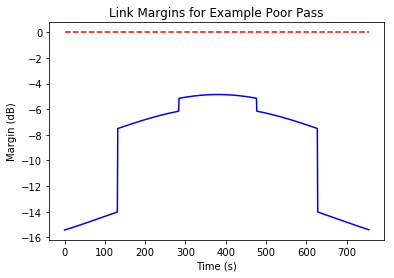

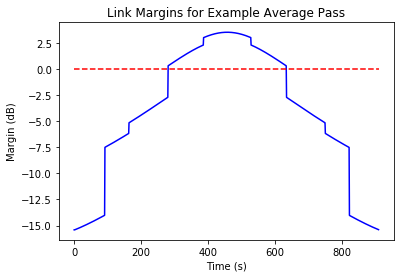

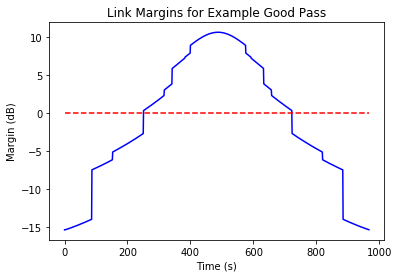

In [19]:
fig = []
types = ['Poor', 'Average', 'Good']

for i in range(0, len(outputs)):
    fig.append(plt.figure())
    p = fig[i].add_subplot(111)
    p.plot(range(0, len(margins[i])), margins[i], 'b', range(0, len(margins[i])), [0] * len(margins[i]), 'r--')
    plt.title('Link Margins for Example {} Pass'.format(types[i]))
    plt.xlabel('Time (s)')
    plt.ylabel('Margin (dB)')

    total_s = 0
    for m in margins[i]:
        if m > 0:
            total_s += 1

    print('Duration for {} pass above margin: {} seconds ({:.3} minutes)'.format(types[i], total_s, total_s/60))

### Conclusions

DETAIL CONCLUSIONS FOR THIS ITERATION

PROBABLY WILL VARY GREATLY FOR EACH ITERATION